# Reinforcement learning tutorial "Taxi driving problem"

Based on https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-2-1b0828a1046b

To install dependencies:
```
    conda install python=3.8 numpy matplotlib pandas jupyterlab
    pip install gym
```

In [1]:
import itertools
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import gym

from IPython.display import clear_output
from tqdm import tqdm

In [2]:
env = gym.make("Taxi-v3").env

In [3]:
env.action_space

Discrete(6)

In [4]:
env.observation_space

Discrete(500)

## Description of policy

`env.P` contains the policy information for a given `state` and `action`.

Variable `state` is from 0 to 499, while `action` from 0 to 5.

`env.P[state][action][0] is a tuple with the following elements:

- probability.
  It is 1.0 in this environment, as the next state is defined deterministically by the current state and the action.
- next_state
  Next state.
- reward
  In this case is -1 as we did not reach the destination.
- done
  True, when we reached the destination.

In [5]:

print(env.P[123][0][0])

(1.0, 223, -1, False)


In [6]:
env.s = 123
print(env.render(mode="human"))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

None


In [7]:
env.s = 223
print(env.render(mode="human"))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

None


## Random agent baseline

Every machine learning project starts with implementing a baseline model.

The actual model is built after to make sure that it works better than the baseline model.

If there is no baseline model, it is very difficult to tell whether the actual model is working good or bad.

The baseline model behaves randomly.

In [8]:
class RandomAgent:
    def __init__(self, env):
        self.env = env

    def get_action(self, state) -> int:
        # This agent does not take `state` into the account
        # and chooses the action randomly.
        # That is, it always explores and never exploits.
        
        return self.env.action_space.sample()
        
agent = RandomAgent(env)

In [9]:
state = 123
env.s = state

epochs = 0
penalties = 0

frames = []

done = False

while not done:
    action = agent.get_action(state)

    state, reward, done, info = env.step(action)
    
    if reward == -10:
        penalties += 1
        
    frames.append({
        "frame": env.render(mode="ansi"),
        "state": state,
        "action": action,
        "reward": reward,
    })
    
    epochs += 1

print("Total number of steps: ", epochs)
print("Number of wall hits: ", penalties)

Total number of steps:  2152
Number of wall hits:  759


In [10]:
n_episodes = 100

timesteps_per_episode = []
penalties_per_episode = []

for i in tqdm(range(0, n_episodes)):
    state = env.reset

    epochs, rewards, penalties = 0, 0, 0

    done = False
    
    while not done:
        action = agent.get_action(state)
        state, reward, done, info = env.step(action)
        
        if reward == -10:
            penalties += 1
            
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 100/100 [00:00<00:00, 128.27it/s]


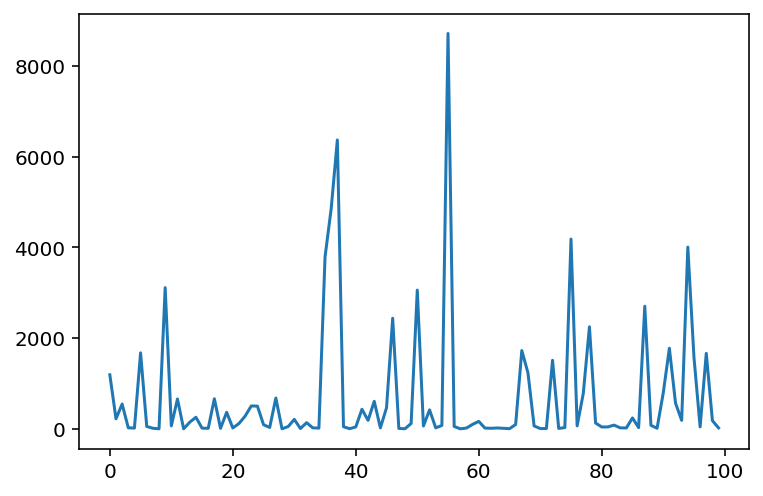

In [11]:
plt.figure()
plt.plot(timesteps_per_episode, "-")

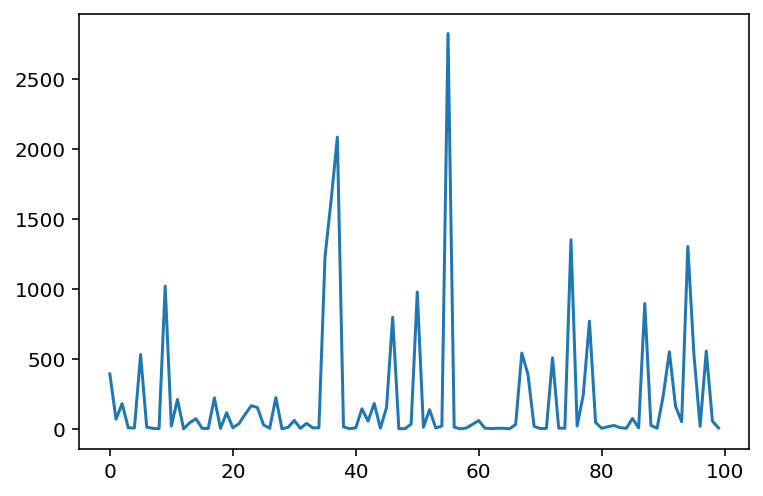

In [12]:
plt.figure()
plt.plot(penalties_per_episode, "-")

## Q-learning agent

Q-learning is an algorithm for learning q-value function.

Q-value function $Q_\pi(s, a)$ is the function that computes the total reward obtained by following policy $\pi$ starting from state $s$ and taking action $a$.

Q-learning obtains successive approximation of the optimal q-value functions starting from an initial guess:
$$
Q^0(s, a) \to Q^1(s, a) \to \dots \to Q^*(s, a)
$$

The update formula for the q-learning is
$$
Q^{\text{new}} = Q^{\text{old}} + \alpha \left(
    r + \gamma \max_a Q^{\text{old}}(s', a) - Q^{\text{old}}(s, a)
\right)
$$

The learning rate $\alpha$ controls the size of updates of the value function.
As usual in ML, too large values of $\alpha$ cause unstable training, while too small values can lead to overfitting due to local minima.

The discount factor $\gamma$ balances the reward at current time and the future rewards.
When $\gamma = 0$, the agent cares only about the immediate reward.
When $\gamma = 1$, the agent cares about all the rewards, current and future ones, with the same care.
Typically, $\gamma$ is somewhere in between zero and unity.

In summary, if the training process is long enough, the values of $\alpha$ and $\gamma$ are good (they are hyperparameters), the balance between exploration and exploitation is good, then the sequence of q-value function approximations converges to the optimal value $Q^*(s, a)$.

In [13]:
class QAgent:
    """Agent that implements q-learning algorithm."""
    def __init__(self, env, alpha, gamma):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        
        self.q_table = np.zeros(
            (self.env.observation_space.n, self.env.action_space.n)
        )
        
    def get_action(self, state):
        return np.argmax(self.q_table[state])
        
    def update_parameters(self, state, action, reward, next_state):
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        
        new_value = old_value + self.alpha * (
            reward + self.gamma * next_max - old_value
        )
        
        self.q_table[state, action] = new_value
        
    def reset(self):
        """Reset the agent to the initial state."""
        self.q_table = np.zeros(
            (self.env.observation_space.n, self.env.action_space.n)
        )

In [14]:
alpha = 0.1
gamma = 0.6

agent = QAgent(env, alpha, gamma)

In [15]:
# Exploration-exploitation hyperparameter.
eps = 0.1

n_episodes = 10**4

timesteps_per_episode = []
penalties_per_episode = []

for i in tqdm(range(n_episodes)):
    state = env.reset()
    
    epochs, penalties, reward = 0, 0, 0

    done = False
    
    while not done:
        if random.uniform(0, 1) < eps:
            action = env.action_space.sample()
        else:
            action = agent.get_action(state)
            
        next_state, reward, done, info = env.step(action)
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████| 10000/10000 [00:05<00:00, 1833.48it/s]


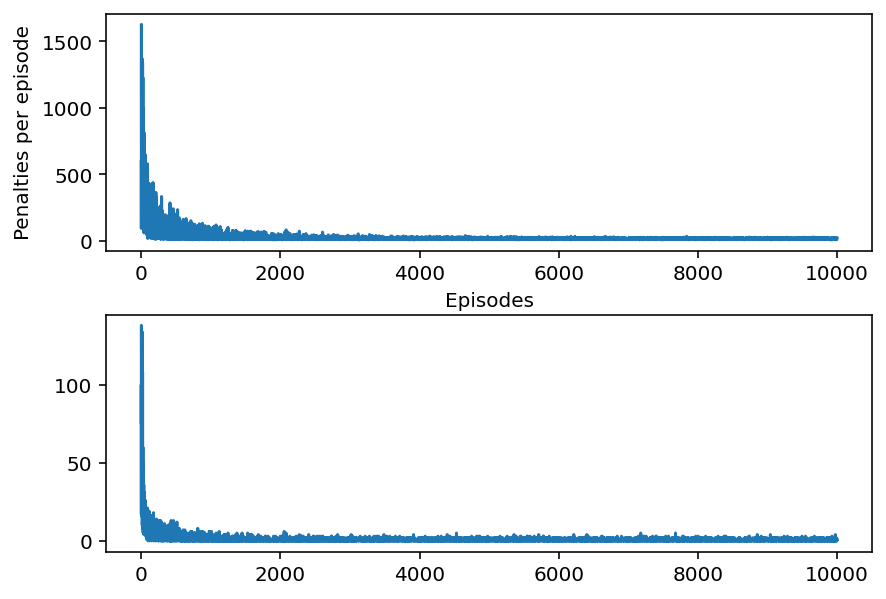

In [16]:
fig, axes = plt.subplots(nrows=2)
axes[0].plot(timesteps_per_episode, "-")
axes[0].set_xlabel(r"Episodes")
axes[0].set_ylabel(r"Time steps per episode")
axes[1].plot(penalties_per_episode, "-")
axes[0].set_xlabel(r"Episodes")
axes[0].set_ylabel(r"Penalties per episode")
fig.tight_layout(pad=0.1)

## Visualizing agent's performance

In [17]:
env.s = 123
state = env.s

epochs, penalties, reward = 0, 0, 0

done = False

frames = []

while not done:
    action = agent.get_action(state)
    state, reward, done, info = env.step(action)
    
    if reward == -10:
        penalties += 1
        
    frames.append({
        "frame": env.render(mode="ansi"),
        "state": state,
        "action": action,
        "reward": reward,
    })
    
    epochs += 1
    
print("Number of epochs: ", epochs)
print("Number of penalties: ", penalties)

Number of epochs:  11
Number of penalties:  0


In [18]:
plt.figure();

for i, f in enumerate(frames):
    clear_output(wait=True)
    print("Frame #{}".format(i+1))
    print(f["frame"])
    print("Reward: {}".format(f["reward"]))
    time.sleep(0.5)

Frame #11
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Reward: 20


<Figure size 432x288 with 0 Axes>

## Evaluating agent's performance

When evaluating agent's performance, it makes sense to slightly randomize its behavior.
If the agent acts only according to the learned policy, it is possible that it stucks in an infinite loop.
If we allow for a little bit of exploration (but taking small `eps`), it can improve the performance.

Below we check how the performance depends on the value of epsilon.

In [19]:
from actions import evaluate

eps_list = [0.05, 0.01, 0.001, 0.0001]
    
for eps in eps_list:
    timesteps_per_episode, penalties_per_episode = evaluate(agent, env, eps, n_episodes=100)
    print(f"===")
    print(f"eps = {eps}")
    print(f"Average number of timesteps: {np.mean(timesteps_per_episode)}")
    print(f"Average number of penalties: {np.mean(penalties_per_episode)}")

100%|██████████| 100/100 [00:00<00:00, 2729.85it/s]


===
eps = 0.05
Average number of timesteps: 22.66
Average number of penalties: 0.34


100%|██████████| 100/100 [00:00<00:00, 2290.32it/s]


===
eps = 0.01
Average number of timesteps: 26.68
Average number of penalties: 0.1


100%|██████████| 100/100 [00:00<00:00, 123.70it/s]


===
eps = 0.001
Average number of timesteps: 829.37
Average number of penalties: 0.28


100%|██████████| 100/100 [00:02<00:00, 38.17it/s]

===
eps = 0.0001
Average number of timesteps: 3324.09
Average number of penalties: 0.08


We can see that when `eps` decreases, the number of time steps increases because the learned policy is imperfect.
This means that for some starting states, the agent acts in a not efficient way.

## Hyperparameter tuning

For hyperparametet tuning, let's encapsulate training and evaluating functions such that the code that uses them is consise.

In [20]:
def evaluate(agent, env, eps=0.05, n_episodes=100):
    timesteps_per_episode = []
    penalties_per_episode = []

    for i in tqdm(range(n_episodes)):
        state = env.reset()
        
        epochs, penalties, reward = 0, 0, 0

        done = False
        
        while not done:
            if random.uniform(0, 1) < eps:
                action = env.action_space.sample()
            else:
                action = agent.get_action(state)
                
            next_state, reward, done, info = env.step(action)
            
            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
            
        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)
        
    return timesteps_per_episode, penalties_per_episode


def train(agent, env, eps=0.1, n_episodes=100, show_progress=True):
    timesteps_per_episode = []
    penalties_per_episode = []
    
    if show_progress:
        episodes = tqdm(range(n_episodes))
    else:
        episodes = range(n_episodes)

    for i in episodes:
        state = env.reset()
        
        epochs, penalties, reward = 0, 0, 0

        done = False
        
        while not done:
            if random.uniform(0, 1) < eps:
                action = env.action_space.sample()
            else:
                action = agent.get_action(state)
                
            next_state, reward, done, info = env.step(action)
            
            agent.update_parameters(state, action, reward, next_state)
            
            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
            
        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)

    return timesteps_per_episode, penalties_per_episode
    
def train_n_runs(agent, env, eps, n_episodes, n_runs):
    res = pd.DataFrame()
    
    for n in tqdm(range(n_runs)):
        agent.reset()
        timesteps, penalties = train(
            agent, env, eps, n_episodes, show_progress=False
        ) 

        res = pd.concat([
            res,
            pd.DataFrame({
                "timesteps_per_episode": timesteps,
                "penalties_per_episode": penalties,
                "run": n,
            })
        ])

    return res

In [21]:
alpha_list = [0.1, 1.0]
gamma_list = [0.1, 0.6, 0.9]

eps = 0.1
n_episodes = 1000
n_runs = 10

results = pd.DataFrame()

for alpha in alpha_list:
    for gamma in gamma_list:
        agent = QAgent(env, alpha, gamma)
        scores = train_n_runs(agent, env, eps, n_episodes, n_runs)

        scores["alpha"] = alpha
        scores["gamma"] = gamma
        results = pd.concat([results, scores]) 

100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


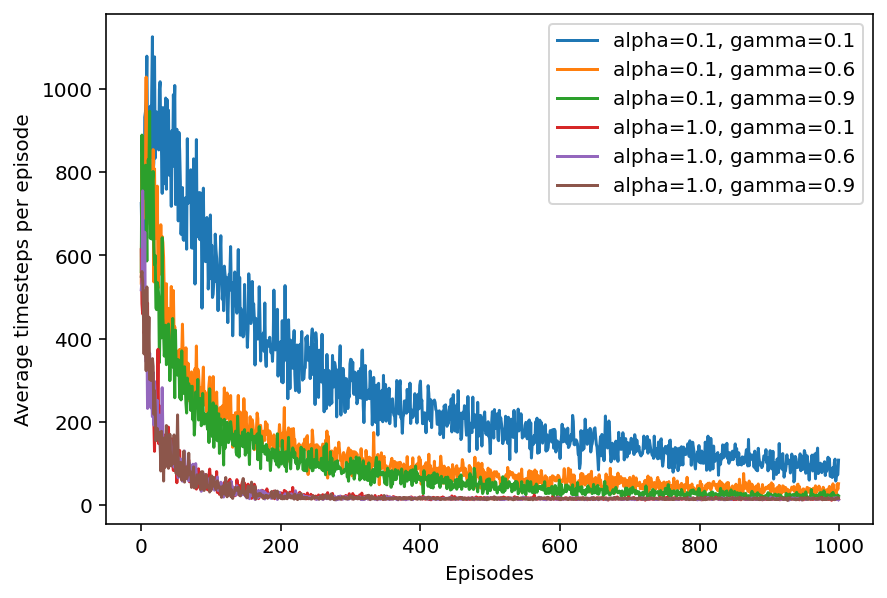

In [22]:
plt.figure()

for (alpha, gamma) in itertools.product(alpha_list, gamma_list):
    selected_results = results[(results.alpha == alpha) & (results.gamma == gamma)]
    # Argument `level=0` groups data by index as the index is non-unique
    # and corresponds to the episode number.
    mean_results = selected_results.groupby(level=0).mean()
    label=f"alpha={alpha}, gamma={gamma}"
    plt.plot(mean_results["timesteps_per_episode"], label=label)

plt.legend(loc="best")
plt.xlabel("Episodes")
plt.ylabel("Average timesteps per episode")
plt.tight_layout(pad=0.1)

We can see from the above figure, that larger values of $\alpha$ improve the training, as it requires less number of episodes to achieve smaller number of timesteps.
At the same time, we can say that the results are not sensitive to $\gamma$.

Each plot is an average of several runs. See the value of `n_runs`.

## Optimization of $\epsilon$

We fix values of $\alpha$ and $\gamma$ and vary $\epsilon$.

In [23]:
eps_list = [0.01, 0.1, 0.9]

n_episodes = 1000
n_runs = 10

for eps in eps_list:
    agent = QAgent(env, 1.0, 0.9)
    scores = train_n_runs(agent, env, eps, n_episodes, n_runs)  

    scores["eps"] = eps
    results = pd.concat([results, scores]) 

100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


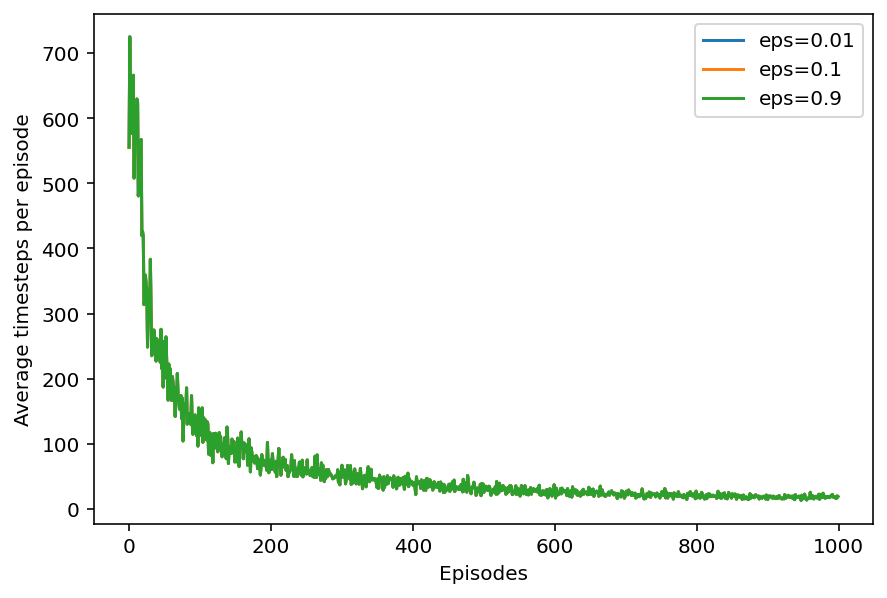

In [24]:
plt.figure()

for eps in eps_list:
    selected_results = results[(results.gamma == gamma)]
    # Argument `level=0` groups data by index as the index is non-unique
    # and corresponds to the episode number.
    mean_results = selected_results.groupby(level=0).mean()
    label=f"eps={eps}"
    plt.plot(mean_results["timesteps_per_episode"], label=label)

plt.legend(loc="best")
plt.xlabel("Episodes")
plt.ylabel("Average timesteps per episode")
plt.tight_layout(pad=0.1)